In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

weather_data = pd.read_csv('../data/miami_weather_combined_daily.csv')
weather_data.head()

,date,weather_code,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,1940-01-02 00:00:00+00:00,51.0,73.2551,55.975100,76.509415,56.151590,0,0,38043.188,33700.754,0.7,0.7,0.0,5.0,8.891343,19.080000,249.737820,12.84,2.245749
1,1940-01-03 00:00:00+00:00,51.0,71.2751,62.725100,71.049230,63.447296,0,0,38068.445,32820.055,1.3,1.3,0.0,6.0,13.202726,26.280000,338.600130,12.65,2.253451
2,1940-01-04 00:00:00+00:00,53.0,76.2251,59.755100,78.883640,58.821480,0,0,38095.598,31149.346,1.0,1.0,0.0,5.0,13.513193,33.120000,62.664597,12.31,2.284541
3,1940-01-05 00:00:00+00:00,61.0,77.5751,63.175102,80.216590,65.592500,0,0,38124.610,33770.555,1.7,1.7,0.0,5.0,16.099690,39.239998,207.818710,12.85,2.319135
4,1940-01-06 00:00:00+00:00,53.0,75.7751,62.815100,78.979230,65.418960,0,0,38155.445,30616.383,1.3,1.3,0.0,6.0,10.972620,22.319998,340.736360,11.35,2.140070


In [2]:
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data['day_of_year'] = weather_data['date'].dt.dayofyear

# Create sinusoidal features
weather_data['sin_day'] = np.sin(2 * np.pi * weather_data['day_of_year'] / 365)
weather_data['cos_day'] = np.cos(2 * np.pi * weather_data['day_of_year'] / 365)

# Define the columns to shift
columns_to_exclude = ['date', 'day_of_year', 'sin_day', 'cos_day']
columns_to_shift = weather_data.columns.difference(columns_to_exclude)

# Shift the specified columns by 1 and add them as new features
for column in columns_to_shift:
    weather_data[f'yesterday_{column}'] = weather_data[column].shift(1)

# Create a new DataFrame with relevant features
data = weather_data[['date', 'day_of_year', 'sin_day', 'cos_day', 'temperature_2m_max'] + [f'yesterday_{column}' for column in columns_to_shift]]
data = data.dropna()

# Convert the data to numpy arrays
X = data[['sin_day', 'cos_day'] + [f'yesterday_{column}' for column in columns_to_shift]].values
y = data['temperature_2m_max'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [3]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Reshape the input data for LSTM
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Create and train the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions on the scaled testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("explained_variance_score:", explained_variance_score(y_test, y_pred))

# Get the corresponding dates for the testing set
test_dates = data['date'].iloc[-len(X_test):]

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures (LSTM)')
plt.legend()
plt.grid(True)
plt.show()

# Plot a smaller subset of the data
plt.figure(figsize=(12, 6))
plt.plot(test_dates[:30], y_test[:30], label='Actual')
plt.plot(test_dates[:30], y_pred[:30], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures (LSTM)')
plt.legend()
plt.grid(True)
plt.show()

: 

Mean Absolute Error (MAE): 2.0237760698583678
Root Mean Squared Error (RMSE): 2.7213519972684614
explained_variance_score: 0.786423699979474


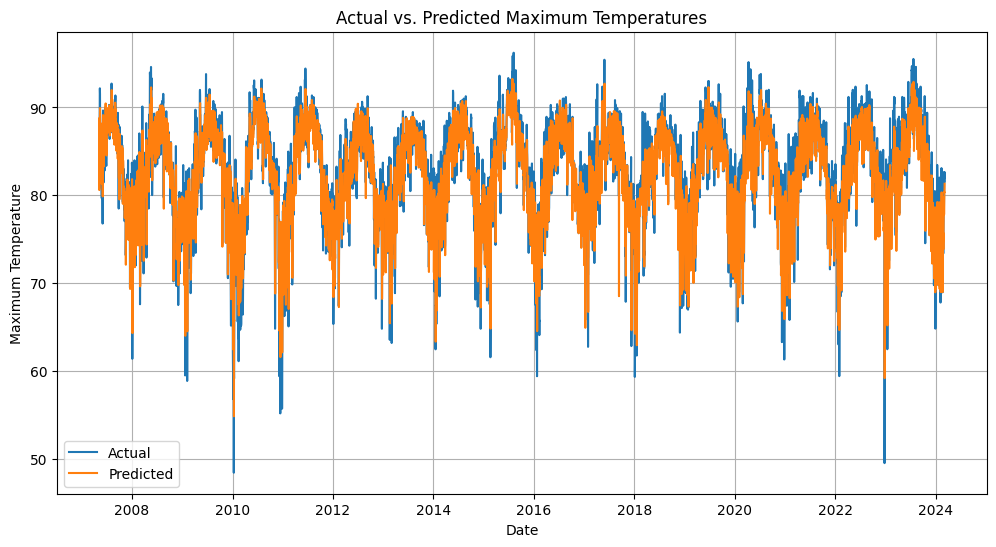

In [32]:
# Linear
# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the scaled testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("explained_variance_score:", explained_variance_score(y_test, y_pred))

# Get the corresponding dates for the testing set
test_dates = data['date'].iloc[-len(X_test):]

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures')
plt.legend()
plt.grid(True)
plt.show()

Mean Absolute Error (MAE) Ridge: 2.0234933626808402
Root Mean Squared Error (RMSE) Ridge: 2.721150934413935
explained_variance_score Ridge: 0.7864482830978498


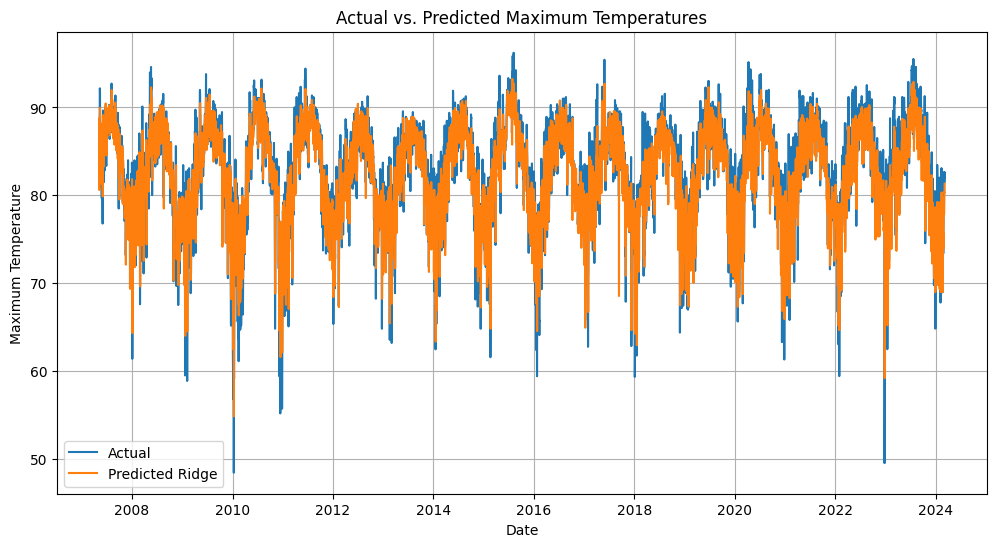

In [33]:
# ridge regression
from sklearn.linear_model import Ridge

model_ridge = Ridge(alpha=0.5)
model_ridge.fit(X_train_scaled, y_train)

y_pred_ridge = model_ridge.predict(X_test_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print("Mean Absolute Error (MAE) Ridge:", mae_ridge)
print("Root Mean Squared Error (RMSE) Ridge:", rmse_ridge)
print("explained_variance_score Ridge:", explained_variance_score(y_test, y_pred_ridge))

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred_ridge, label='Predicted Ridge')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures')
plt.legend()
plt.grid(True)
plt.show()

Mean Absolute Error (MAE) Lasso: 2.0031481750109825
Root Mean Squared Error (RMSE) Lasso: 2.7421895248799593
explained_variance_score Lasso: 0.7793826662839802


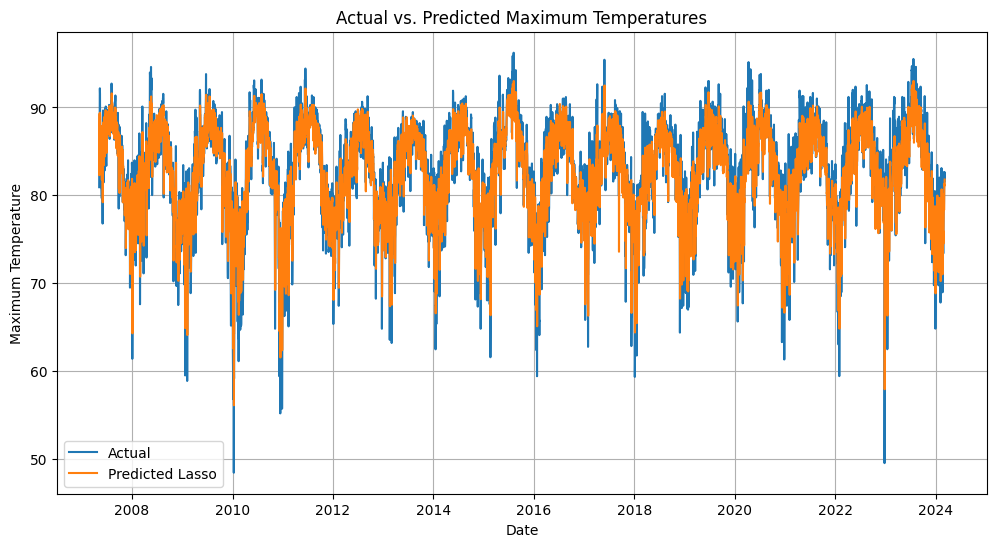

In [34]:
# lasso regression
from sklearn.linear_model import Lasso

model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train_scaled, y_train)

y_pred_lasso = model_lasso.predict(X_test_scaled)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("Mean Absolute Error (MAE) Lasso:", mae_lasso)
print("Root Mean Squared Error (RMSE) Lasso:", rmse_lasso)
print("explained_variance_score Lasso:", explained_variance_score(y_test, y_pred_lasso))

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred_lasso, label='Predicted Lasso')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures')
plt.legend()
plt.grid(True)
plt.show()

Mean Absolute Error (MAE) ElasticNet: 2.0470565218358105
Root Mean Squared Error (RMSE) ElasticNet: 2.7662632801130793
explained_variance_score ElasticNet: 0.7772821786186903


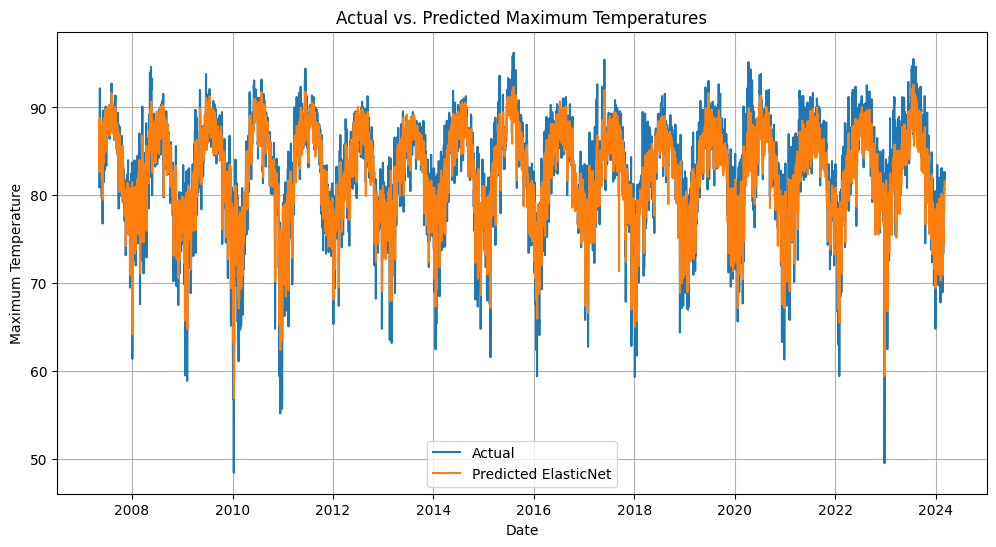

In [35]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.5)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE) ElasticNet:", mae)
print("Root Mean Squared Error (RMSE) ElasticNet:", rmse)
print("explained_variance_score ElasticNet:", explained_variance_score(y_test, y_pred))

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted ElasticNet')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures')
plt.legend()
plt.grid(True)
plt.show()

Mean Absolute Error (MAE) DecisionTree: 2.019017245897797
Root Mean Squared Error (RMSE) DecisionTree: 2.776806492288606
explained_variance_score DecisionTree: 0.7723504909111614


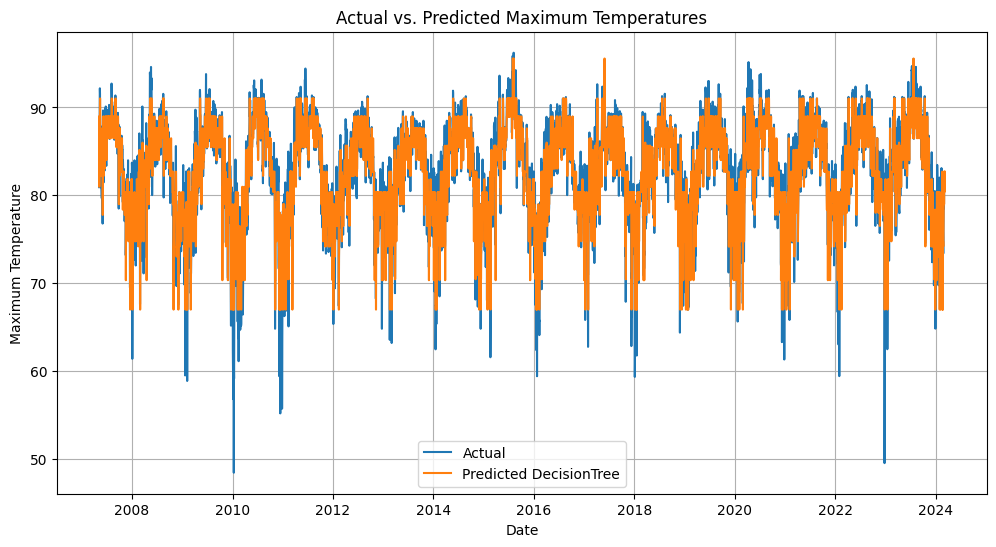

In [36]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE) DecisionTree:", mae)
print("Root Mean Squared Error (RMSE) DecisionTree:", rmse)
print("explained_variance_score DecisionTree:", explained_variance_score(y_test, y_pred))

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted DecisionTree')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Absolute Error (MAE) RandomForest: 1.8571252393412623
Root Mean Squared Error (RMSE) RandomForest: 2.516235484208214
explained_variance_score RandomForest: 0.815114133607872


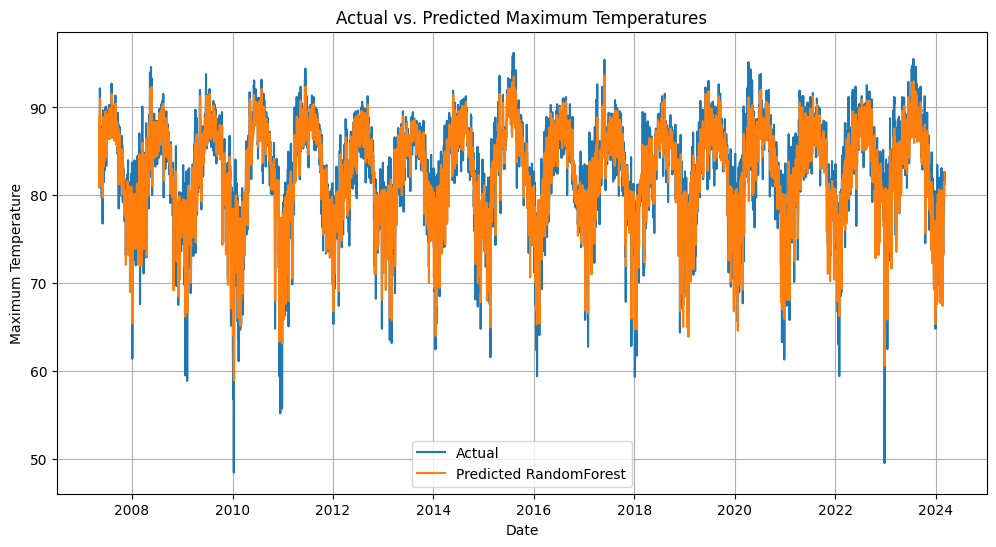

In [37]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE) RandomForest:", mae)
print("Root Mean Squared Error (RMSE) RandomForest:", rmse)
print("explained_variance_score RandomForest:", explained_variance_score(y_test, y_pred))

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted RandomForest')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (MAE) GradientBoosting: 1.8858391437886144
Root Mean Squared Error (RMSE) GradientBoosting: 2.5433068673747457
explained_variance_score GradientBoosting: 0.8115634281413169


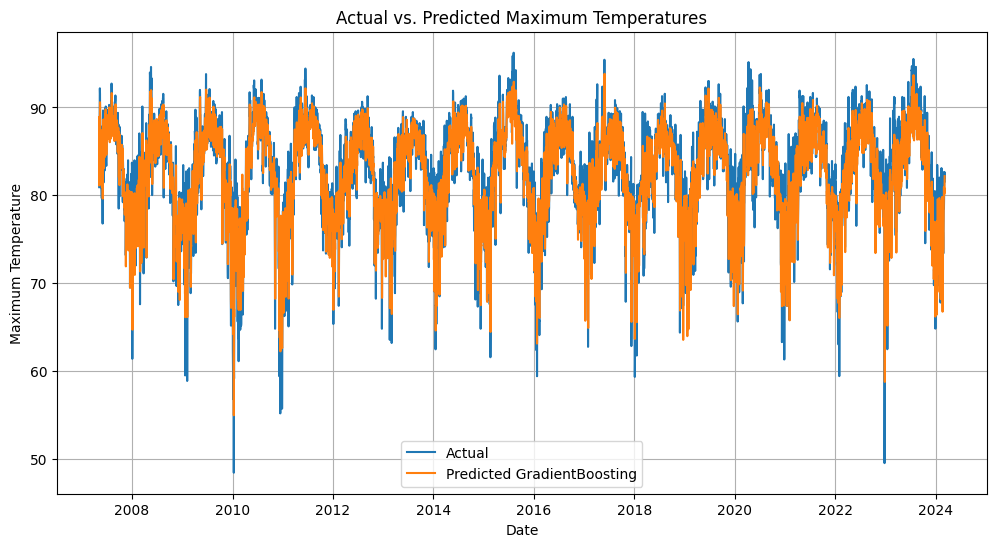

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE) GradientBoosting:", mae)
print("Root Mean Squared Error (RMSE) GradientBoosting:", rmse)
print("explained_variance_score GradientBoosting:", explained_variance_score(y_test, y_pred))

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted GradientBoosting')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (MAE) MLP: 1.9774295275749574
Root Mean Squared Error (RMSE) MLP: 2.6330174557445516
explained_variance_score MLP: 0.8045112360216184


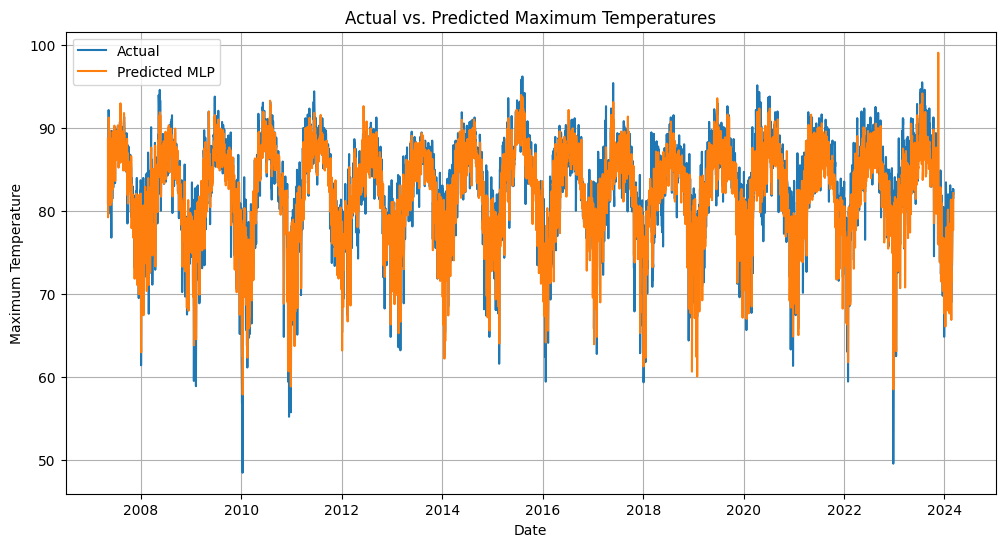

In [39]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(alpha = 0.001, hidden_layer_sizes=(100,50), activation='relu', solver='adam')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE) MLP:", mae)
print("Root Mean Squared Error (RMSE) MLP:", rmse)
print("explained_variance_score MLP:", explained_variance_score(y_test, y_pred))

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted MLP')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (MAE) SVR: 1.8557634445348437
Root Mean Squared Error (RMSE) SVR: 2.5592712175194463
explained_variance_score SVR: 0.8068389778471129


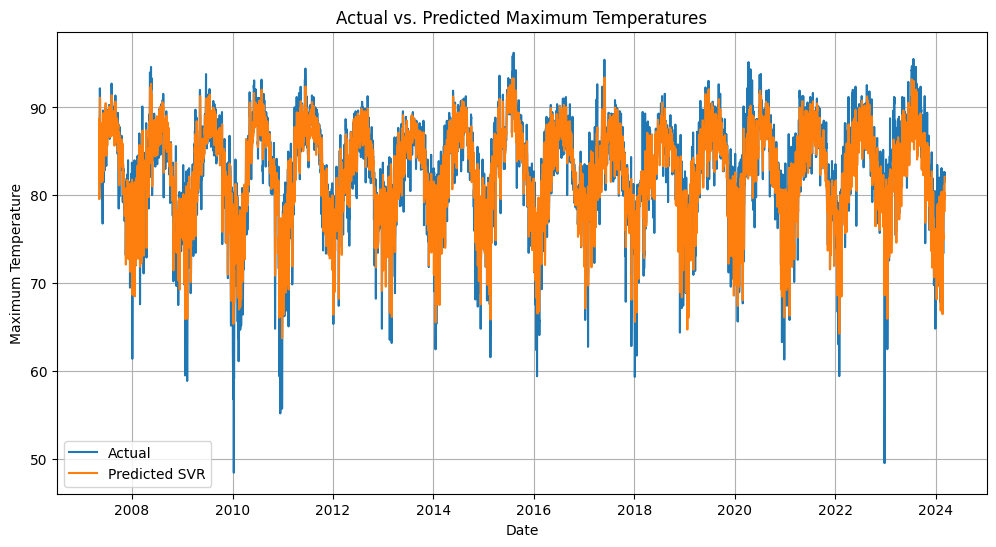

In [40]:
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE) SVR:", mae)
print("Root Mean Squared Error (RMSE) SVR:", rmse)
print("explained_variance_score SVR:", explained_variance_score(y_test, y_pred))

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted SVR')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures')
plt.legend()
plt.grid(True)
plt.show()

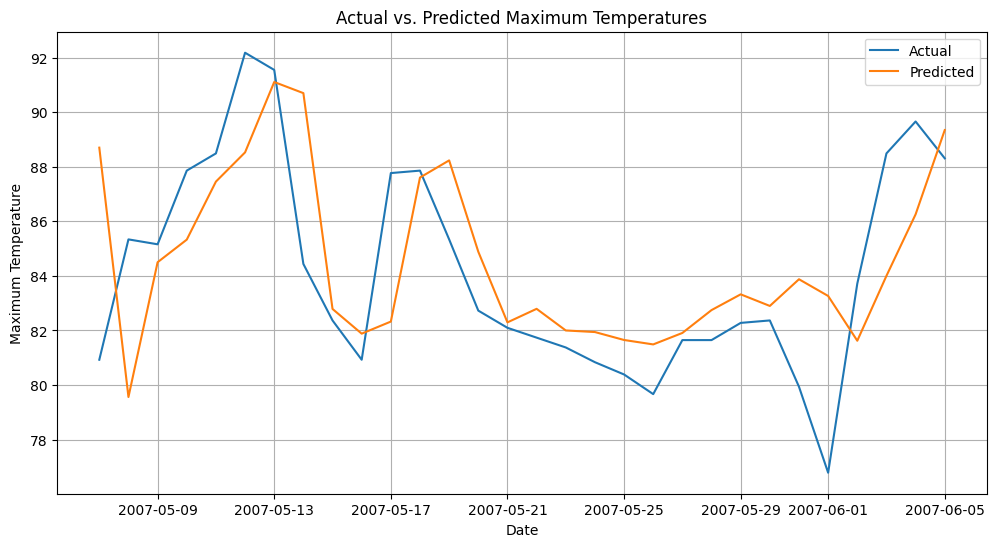

In [41]:
# plot a smaller subset of the data
plt.figure(figsize=(12, 6))
plt.plot(test_dates[:30], y_test[:30], label='Actual')
plt.plot(test_dates[:30], y_pred[:30], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures')
plt.legend()
plt.grid(True)
plt.show()